In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import pylab as mplot
import yaml
import h5py
import scipy.optimize
import tqdm
import healpy as hp
from pylab import cm

In [2]:
import matplotlib.pyplot as plt
dpi = 300
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['lines.markersize'] = 3
plt.rc('lines', dotted_pattern = [2., 2.]) # this makes lines plotted by plt.grid much nicer looking
#if you don't have LaTeX installed on your laptop and this statement 
# generates error, comment it out
#plt.rc('text', usetex=True)

In [3]:
delve_dir = 'metacal_test_1000tiles_20221108_all.hdf' # change this to your directory

In [4]:
with h5py.File(delve_dir, 'r') as h5r:
    print(h5r['DATA'].keys())

<KeysViewHDF5 ['dec', 'flux_i', 'flux_r', 'flux_z', 'good_frac', 'id', 'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_err_1m', 'mcal_T_err_1p', 'mcal_T_err_2m', 'mcal_T_err_2p', 'mcal_T_err_noshear', 'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m', 'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p', 'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_cov_1m', 'mcal_flux_cov_1p', 'mcal_flux_cov_2m', 'mcal_flux_cov_2p', 'mcal_flux_cov_noshear', 'mcal_flux_err_1m', 'mcal_flux_err_1p', 'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear', 'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p', 'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_nfev_1m', 'mcal_nfev_1p', 'mcal_nfev_2m', 'mcal_nfev_2p', 'mcal_nfev_noshear', 'mcal_pars_1m', 'mcal_pars_1p', 'mcal_pars_2m', 'mcal_pars_2p', 'mcal_pars_cov_1m', 'mcal_pars_cov_1p', 'mcal_pars_

16591305


/tmp/ipykernel_9530/3094601159.py:6: RuntimeWarning: invalid value encountered in log10
  mplot.hist2d(np.log10(new['DATA/mcal_s2n_noshear']),new['DATA/mcal_g_noshear'][:,0], range=((-1,2), (-1,1)), bins=(100,100),norm=colors.LogNorm())
/tmp/ipykernel_9530/3094601159.py:12: RuntimeWarning: invalid value encountered in log10
  mplot.hist2d(np.log10(new['DATA/mcal_s2n_noshear']),new['DATA/mcal_g_noshear'][:,1], range=((-1,2), (-1,1)), bins=(100,100),norm=colors.LogNorm())


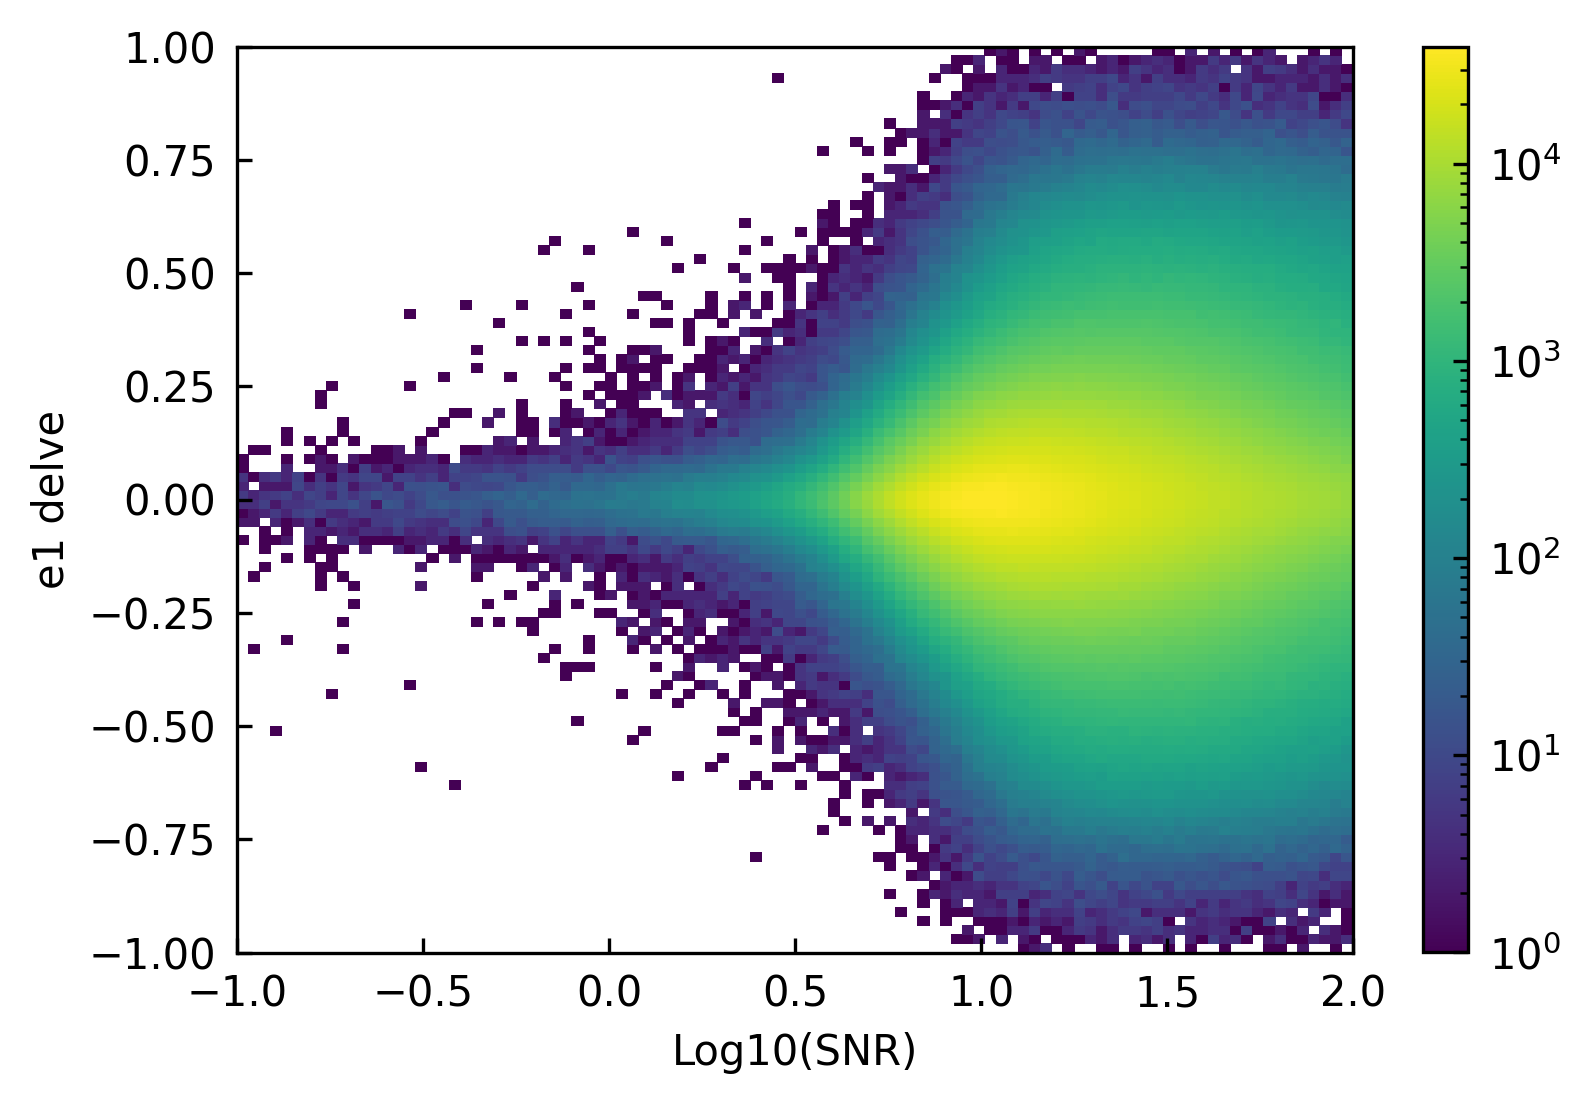

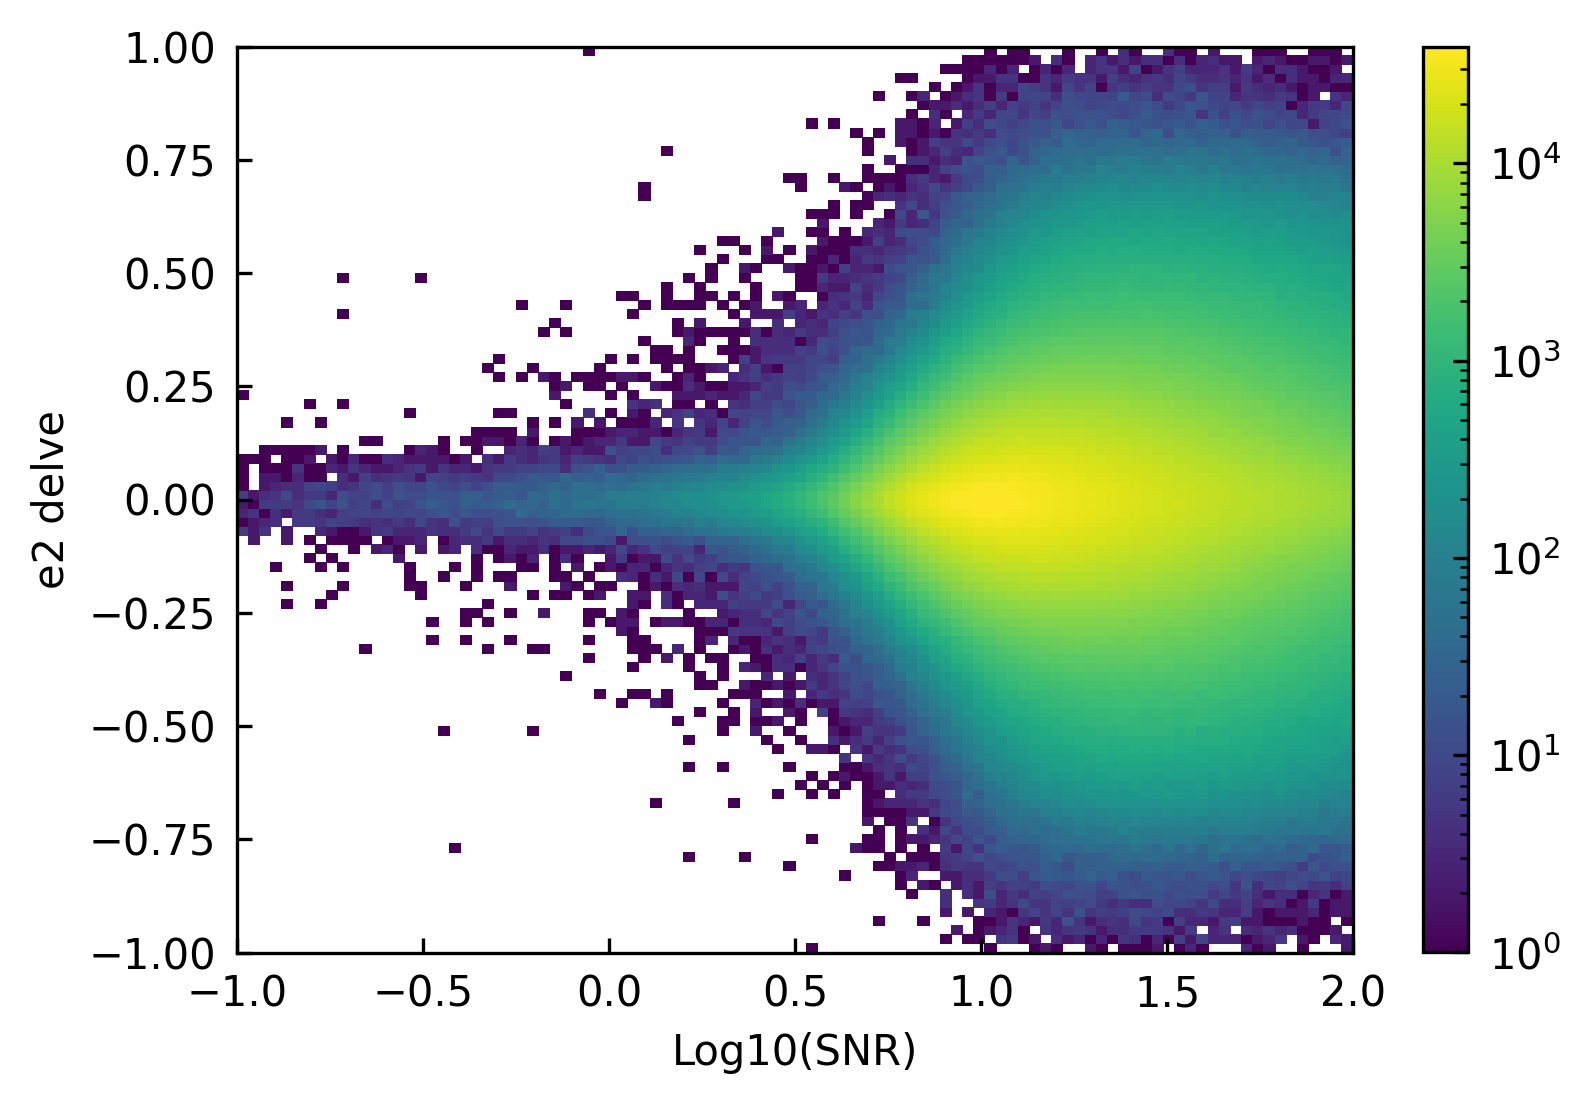

In [5]:
import matplotlib.colors as colors

with h5py.File(delve_dir, 'r') as new:
    print(len(new['DATA/mcal_s2n_noshear']))
    mplot.figure()
    mplot.hist2d(np.log10(new['DATA/mcal_s2n_noshear']),new['DATA/mcal_g_noshear'][:,0], range=((-1,2), (-1,1)), bins=(100,100),norm=colors.LogNorm())
    mplot.colorbar()
    mplot.xlabel('Log10(SNR)')
    mplot.ylabel('e1 delve')

    mplot.figure()
    mplot.hist2d(np.log10(new['DATA/mcal_s2n_noshear']),new['DATA/mcal_g_noshear'][:,1], range=((-1,2), (-1,1)), bins=(100,100),norm=colors.LogNorm())
    mplot.colorbar()
    mplot.xlabel('Log10(SNR)')
    mplot.ylabel('e2 delve')


In [6]:
with h5py.File(delve_dir, 'r') as new:
    print(np.array(new['DATA']['mcal_T_noshear'])>2)

[False False False ... False False False]


# Calibrate for all

In [7]:

with h5py.File(delve_dir, 'r') as X:
    new = X['DATA']
    mask0 = (~((new['mcal_T_noshear'][:]>2)*(new['mcal_s2n_noshear'][:]<30)))*(new['mcal_T_noshear'][:]<10)*(new['mcal_s2n_noshear'][:]<1000)*(new['mcal_s2n_noshear'][:]>10)*(new['mcal_T_ratio_noshear'][:]>0.5)
    mask_1p = (~((new['mcal_T_1p'][:]>2)*(new['mcal_s2n_1p'][:]<30)))*(new['mcal_T_1p'][:]<10)*(new['mcal_s2n_1p'][:]<1000)*(new['mcal_s2n_1p'][:]>10)*(new['mcal_T_ratio_1p'][:]>0.5)
    mask_1m = (~((new['mcal_T_1m'][:]>2)*(new['mcal_s2n_1m'][:]<30)))*(new['mcal_T_1m'][:]<10)*(new['mcal_s2n_1m'][:]<1000)*(new['mcal_s2n_1m'][:]>10)*(new['mcal_T_ratio_1m'][:]>0.5)
    mask_2p = (~((new['mcal_T_2p'][:]>2)*(new['mcal_s2n_2p'][:]<30)))*(new['mcal_T_2p'][:]<10)*(new['mcal_s2n_2p'][:]<1000)*(new['mcal_s2n_2p'][:]>10)*(new['mcal_T_ratio_2p'][:]>0.5)
    mask_2m = (~((new['mcal_T_2m'][:]>2)*(new['mcal_s2n_2m'][:]<30)))*(new['mcal_T_2m'][:]<10)*(new['mcal_s2n_2m'][:]<1000)*(new['mcal_s2n_2m'][:]>10)*(new['mcal_T_ratio_2m'][:]>0.5)

    # calcualte metacalibration factors
    dgamma = 2*0.01

    # add weights to everything

    print("DELVE")

    R11  = (np.mean(new['mcal_g_1p'][:,0][mask0]) - np.mean(new['mcal_g_1m'][:,0][mask0]))/dgamma
    R11s = (np.mean(new['mcal_g_noshear'][:,0][mask_1p]) - np.mean(new['mcal_g_noshear'][:,0][mask_1m]))/dgamma
    R11tot = R11 + R11s
    print('R11_g', R11, 'R11_s', R11s)
    print('R11 tot', R11tot)

    R22  = (np.mean(new['mcal_g_2p'][:,1][mask0]) - np.mean(new['mcal_g_2m'][:,1][mask0]))/dgamma
    R22s = (np.mean(new['mcal_g_noshear'][:,1][mask_2p]) - np.mean(new['mcal_g_noshear'][:,1][mask_2m]))/dgamma
    R22tot = R22 + R22s
    print('R22_g', R22, 'R22_s', R22s)
    print('R22 tot', R22tot)

    print(len(new['mcal_g_2p'][:,1][mask0]))
    print(new['mcal_g_2p'][:,1][mask0])
    
    ra_s = new['ra'][mask0]
    dec_s = new['dec'][mask0]
    e1_s = new['mcal_g_noshear'][:,0]/R11tot
    e2_s = new['mcal_g_noshear'][:,1]/R22tot

DELVE
R11_g 0.692201781127758 R11_s 0.022173657366191965
R11 tot 0.7143754384939499
R22_g 0.6860830838855065 R22_s 0.022931209783751207
R22 tot 0.7090142936692577
8418187
[ 0.3687601  -0.09982538  0.3730218  ...  0.50489117  0.5150706
  0.85646599]


### Trying to make shear maps

In [8]:
nside = 1024
theta_s = (90.0 - dec_s)*np.pi/180.
phi_s = ra_s*np.pi/180.
pix_s = hp.ang2pix(nside,theta_s,phi_s,nest=False)
map_s = np.zeros(hp.nside2npix(nside))
map_s_e1 = np.zeros(hp.nside2npix(nside))
map_s_e2 = np.zeros(hp.nside2npix(nside))

for i in range(len(pix_s)):
    map_s[pix_s[i]] += 1
    map_s_e1[pix_s[i]] += e1_s[i]
    map_s_e2[pix_s[i]] += e2_s[i]

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


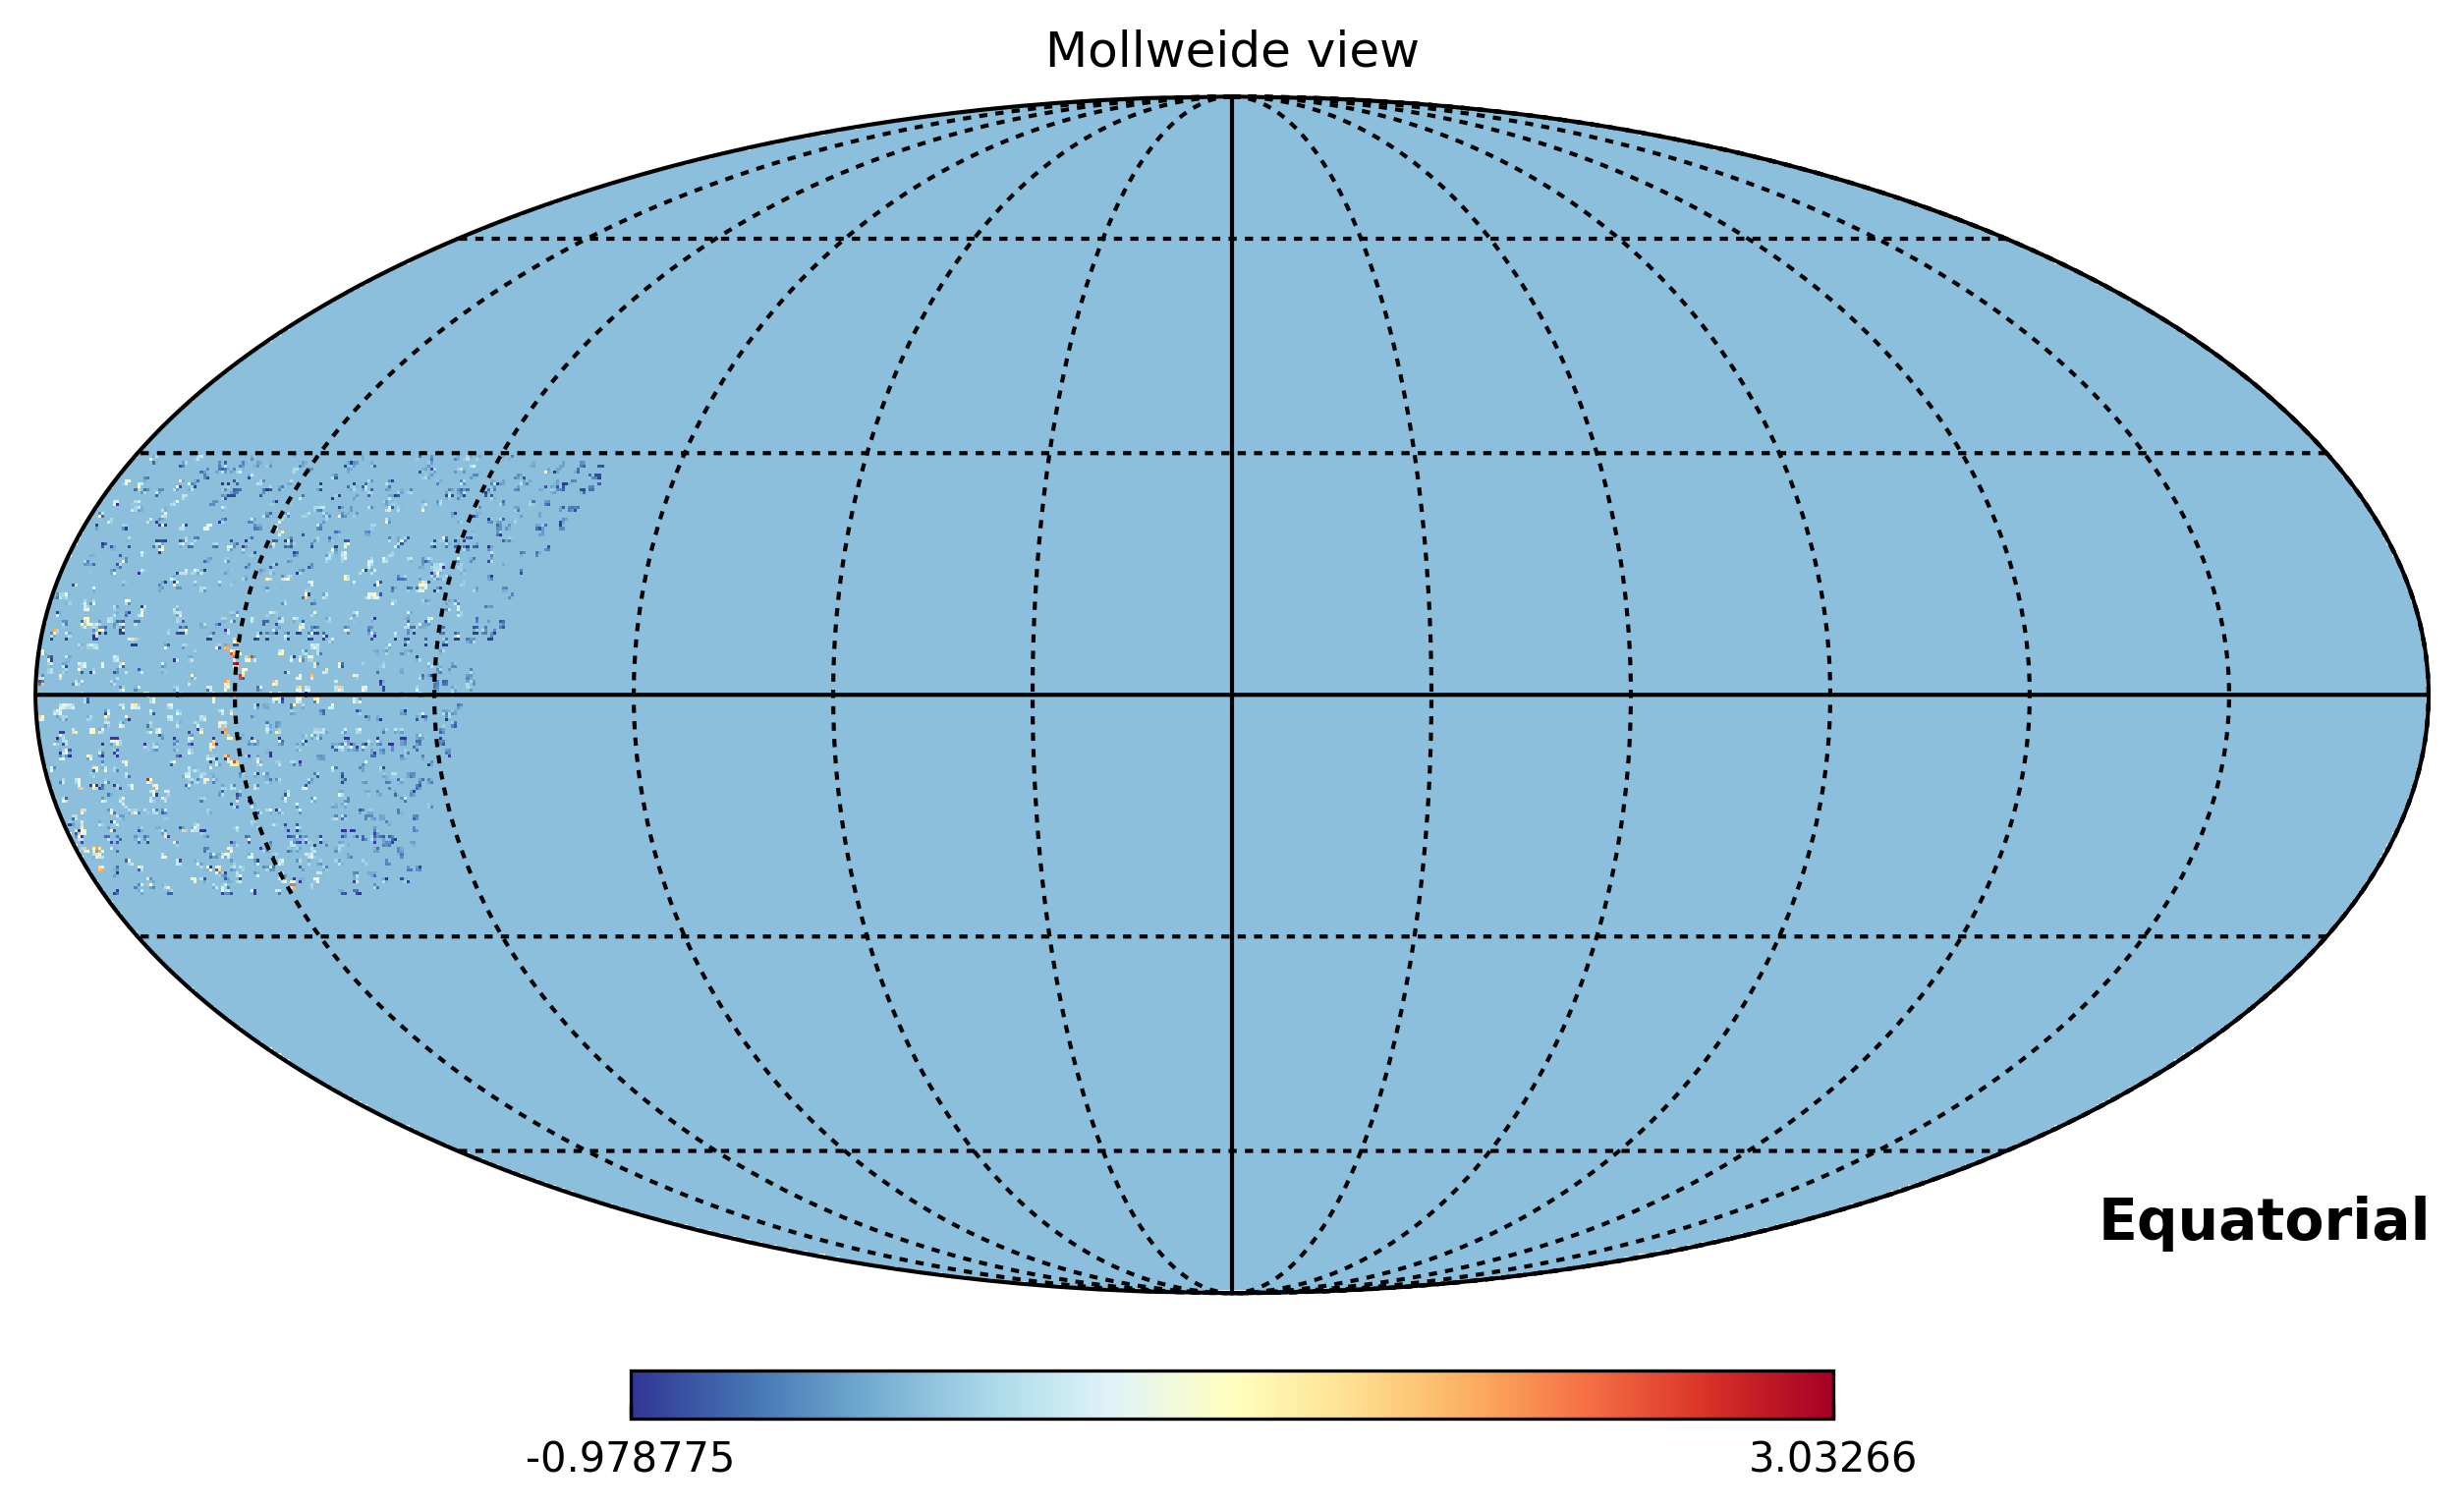

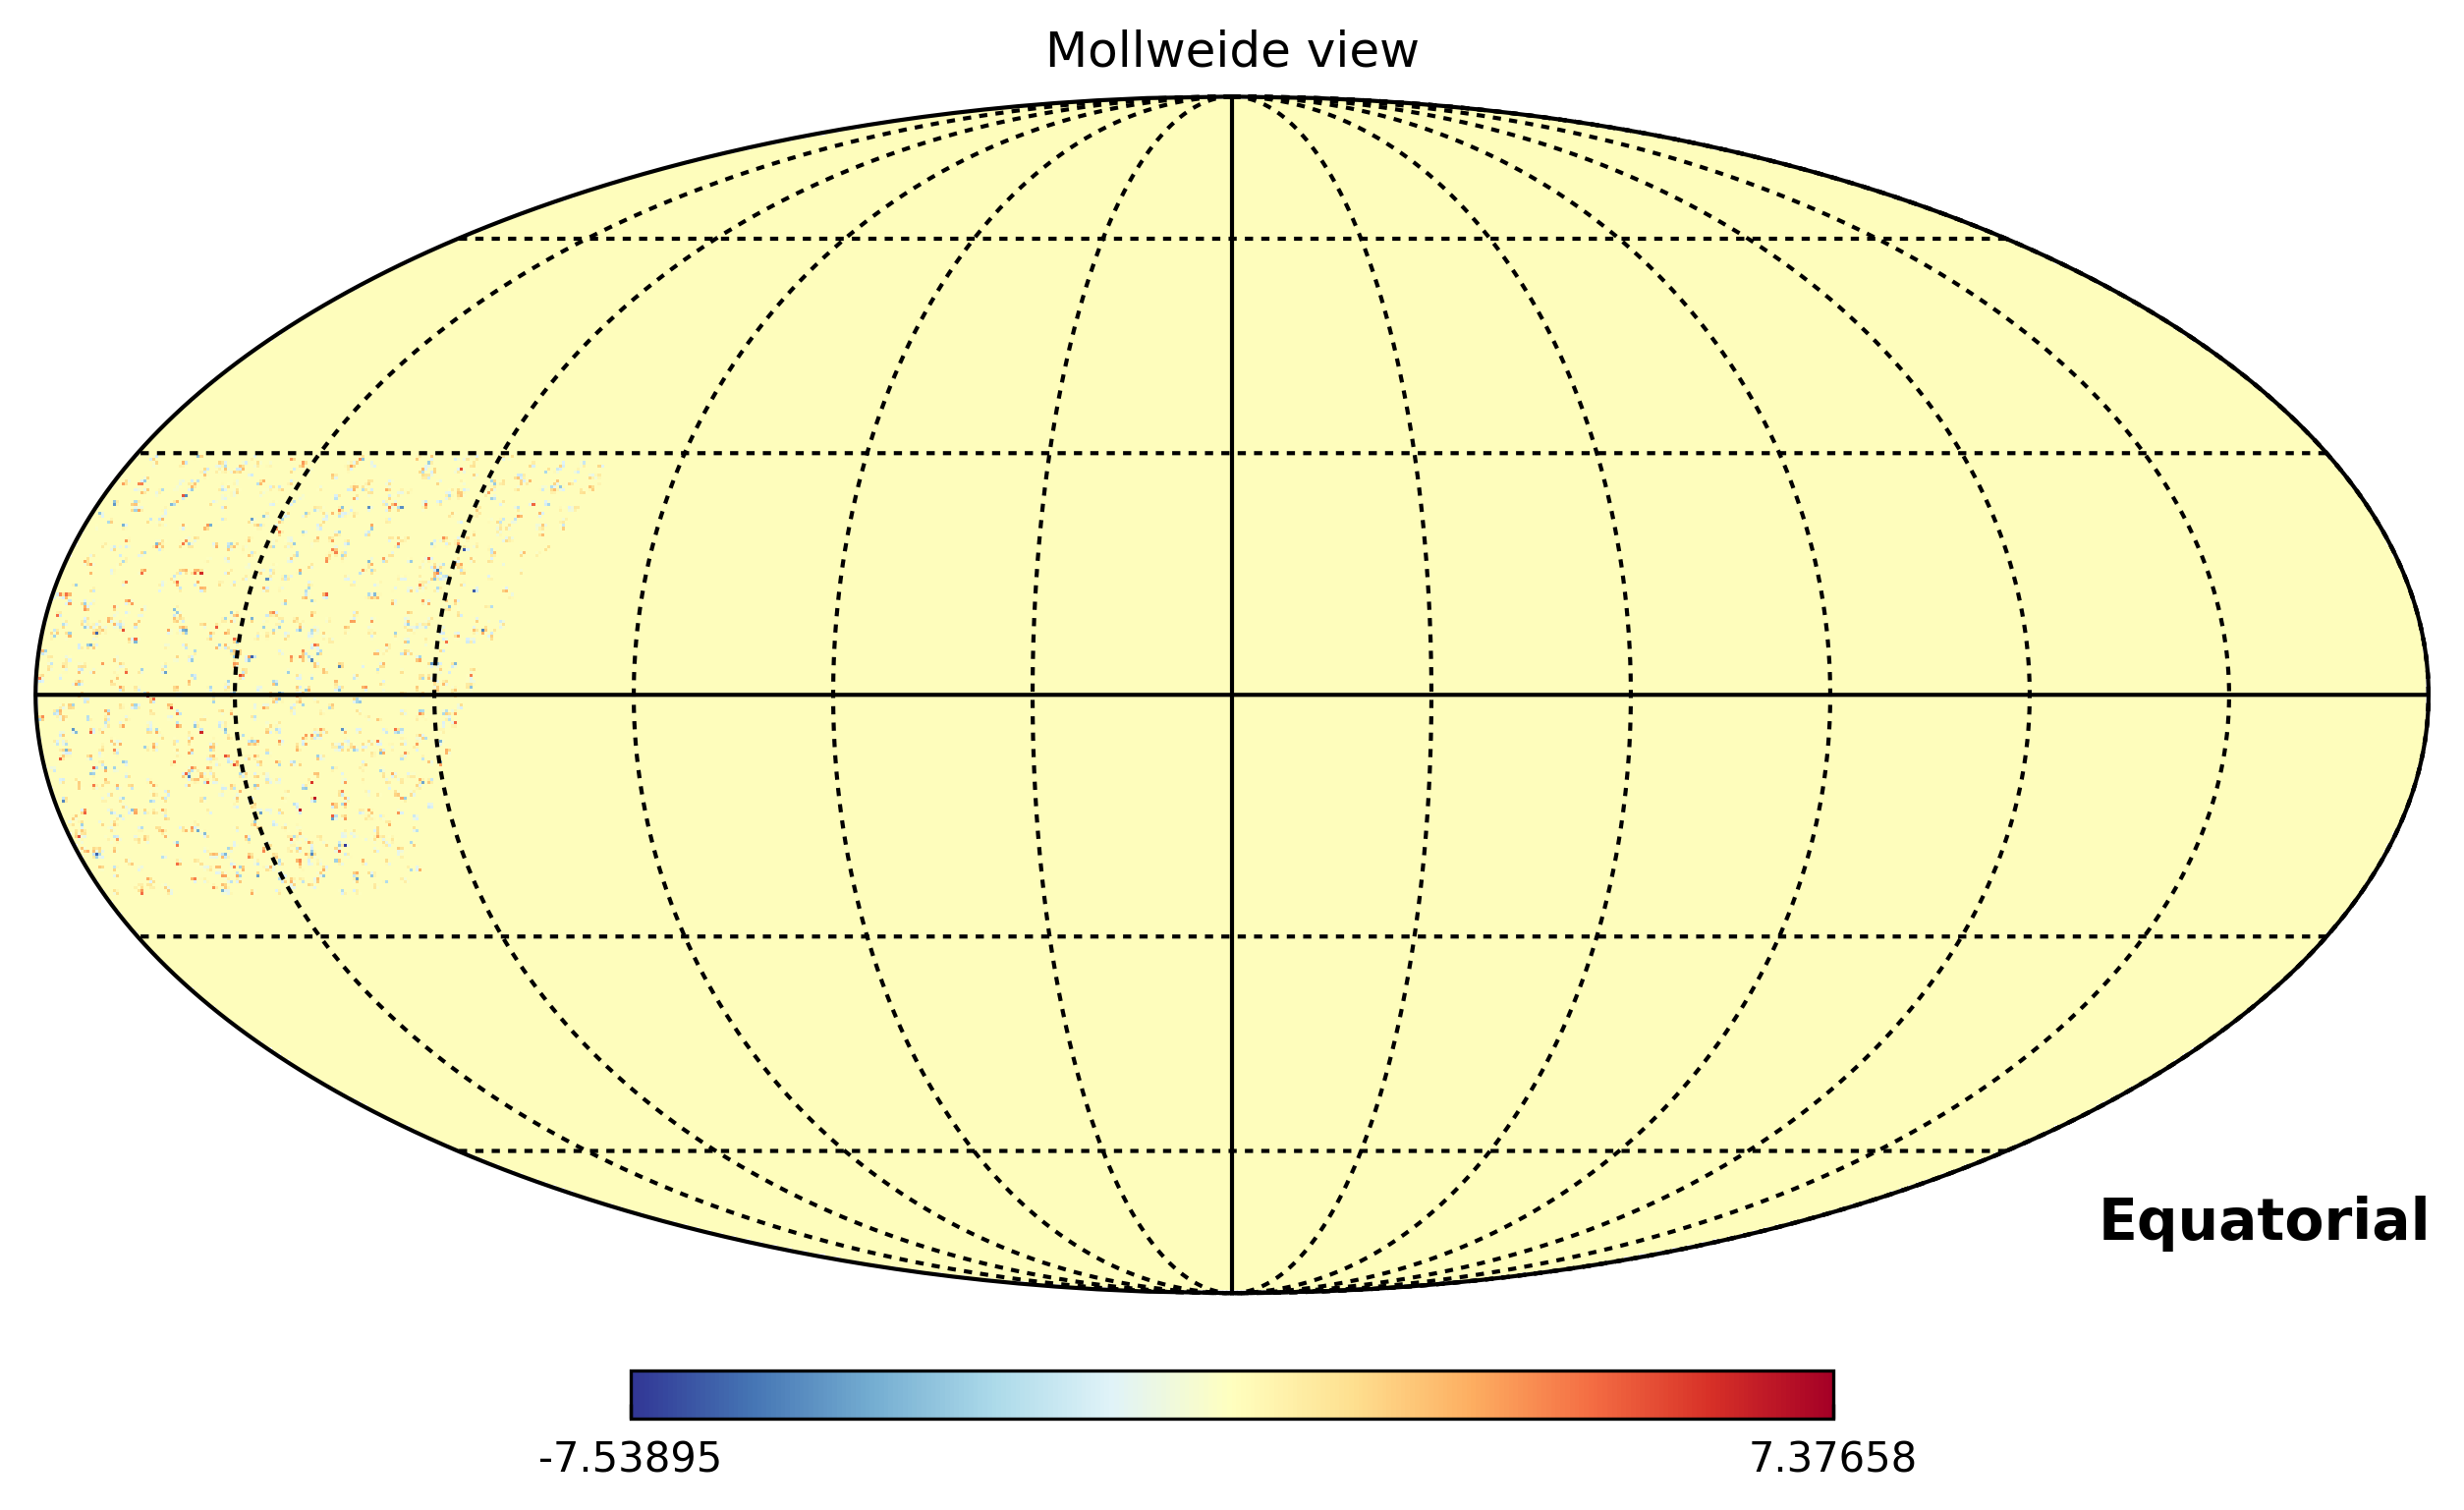

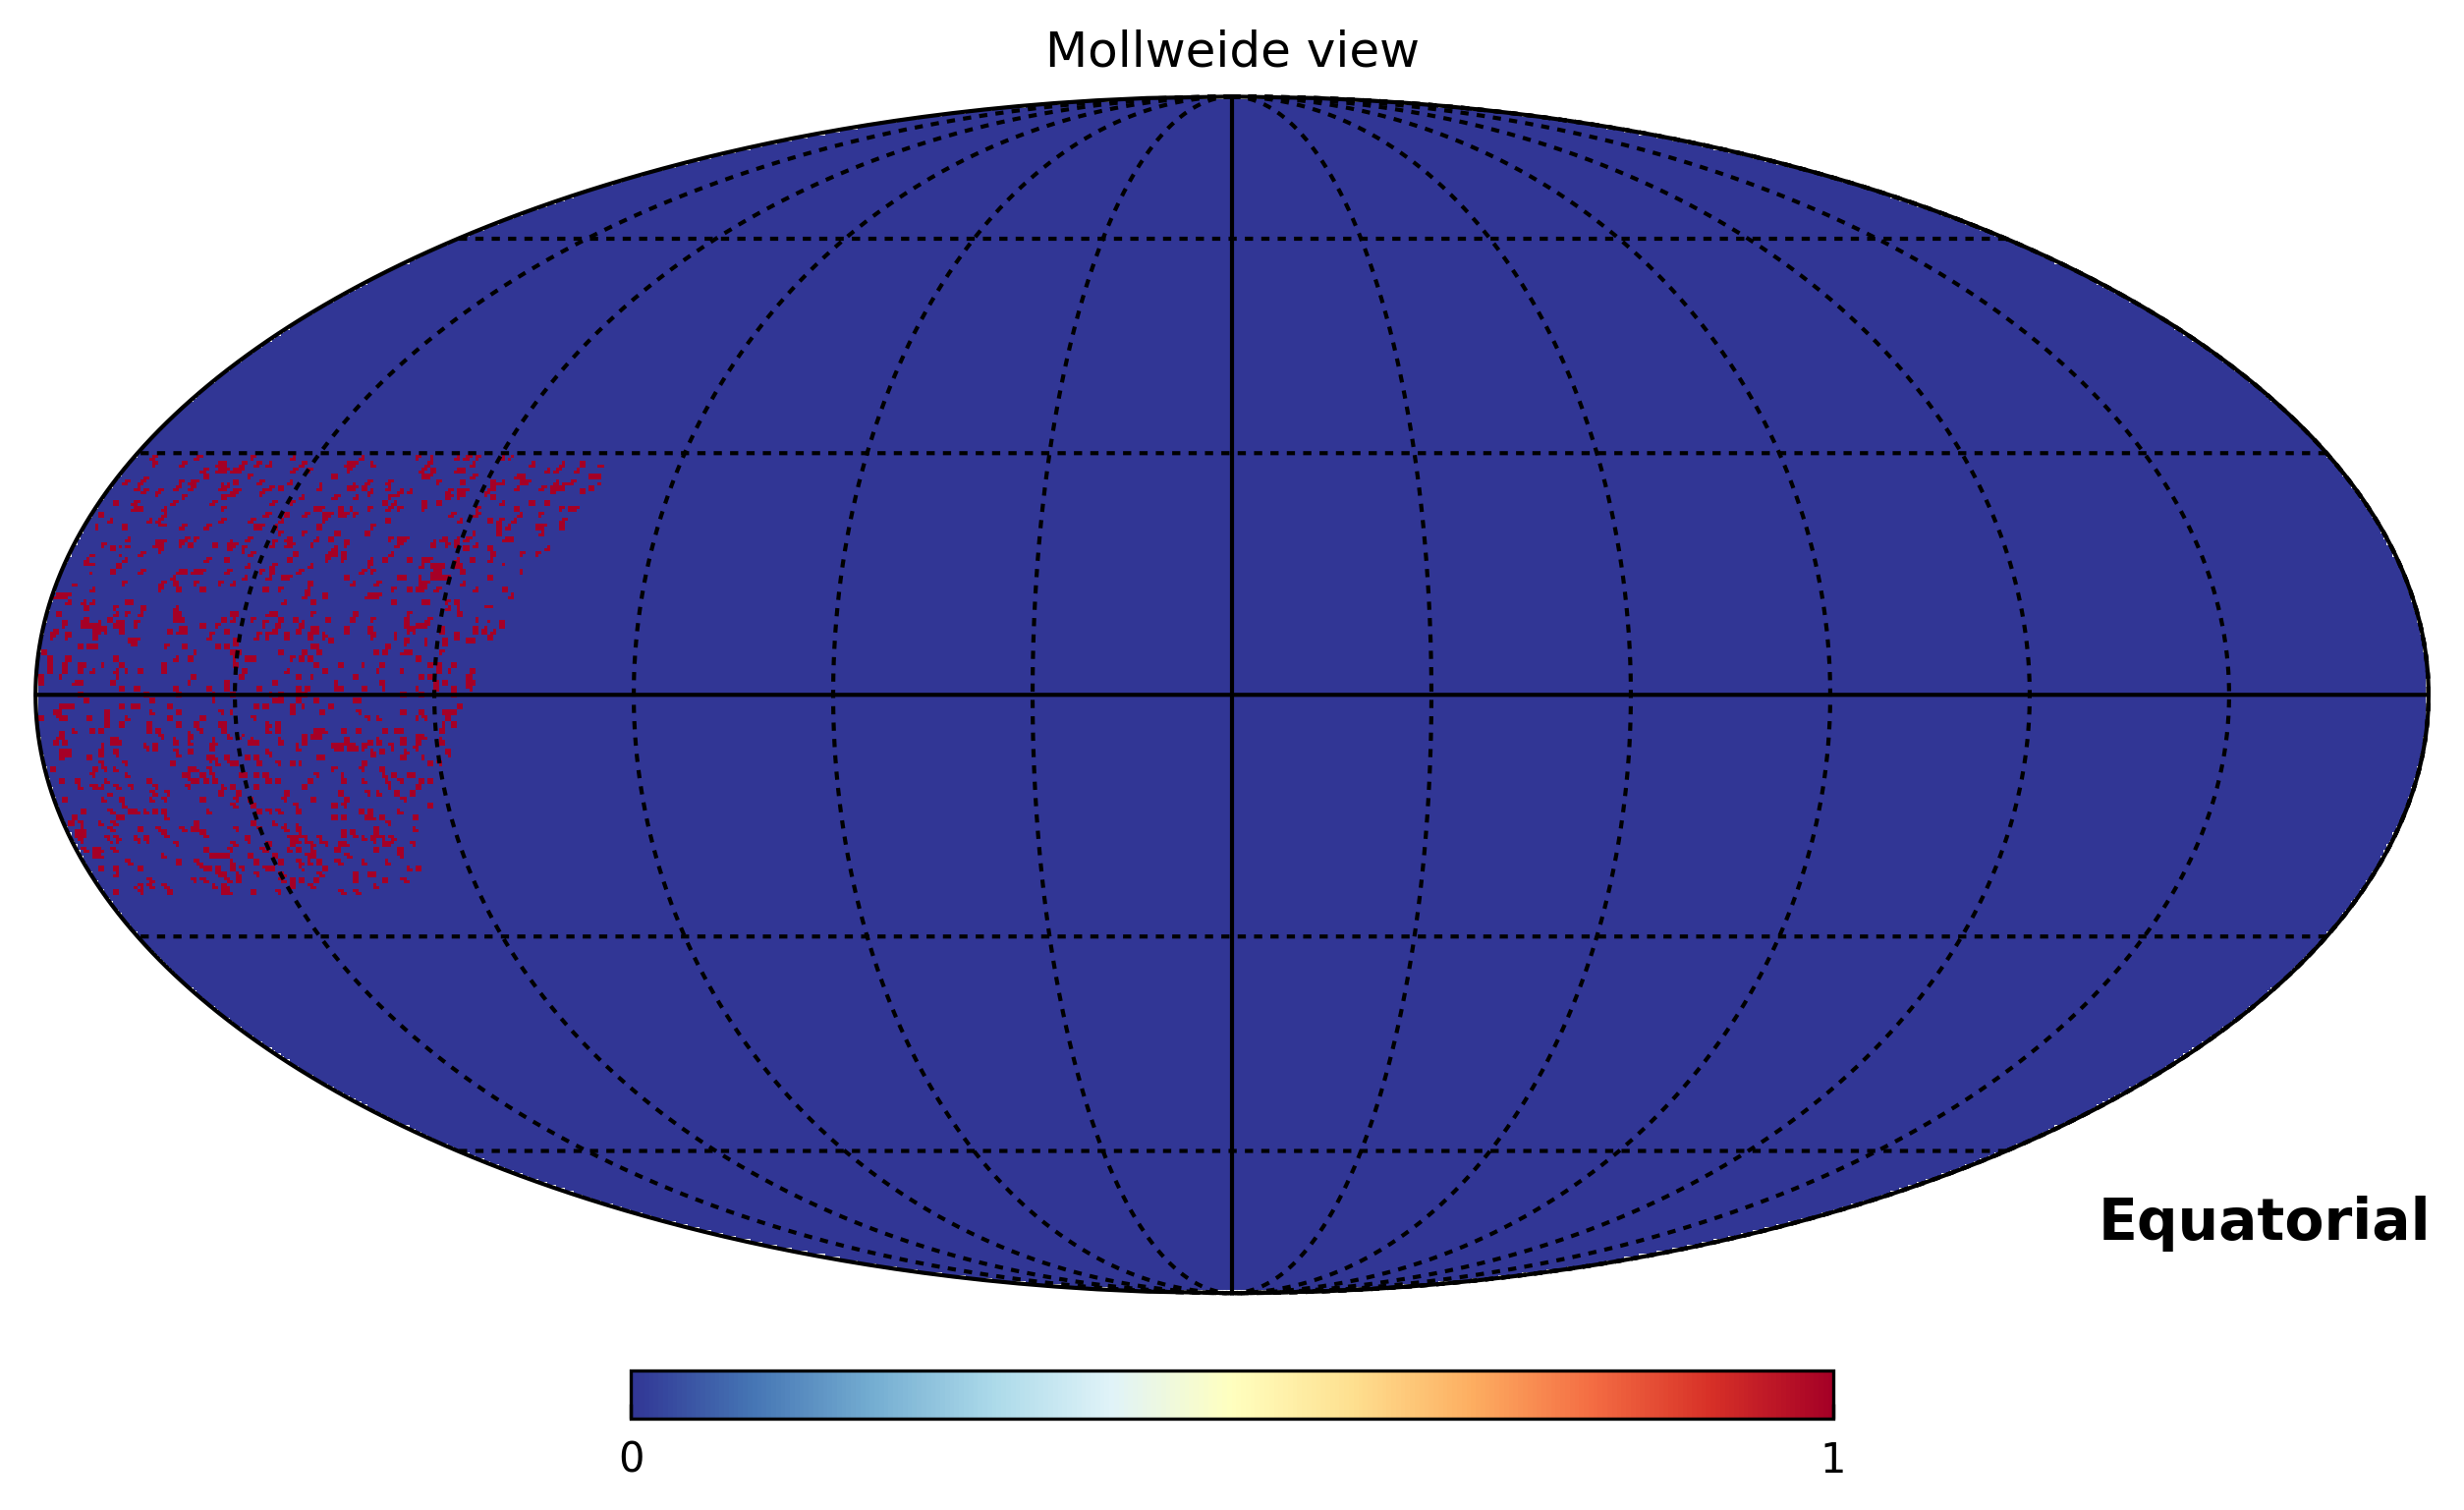

In [9]:
map_s[map_s!=0] = (map_s[map_s!=0]-np.mean(map_s[map_s!=0]))/np.mean(map_s[map_s!=0])

hp.mollview(map_s, coord=['C'], cmap=cm.RdYlBu_r)
hp.graticule(coord="c", verbose=False)

hp.mollview(map_s_e1, coord=['C'], cmap=cm.RdYlBu_r)
hp.graticule(coord="c", verbose=False)

mask = map_s*1.0
mask[mask!=0] = 1

small_map = hp.mollview(mask, coord=['C'], cmap=cm.RdYlBu_r, return_projected_map=True)
hp.graticule(coord="c", verbose=False)


In [10]:
QU_mask = mask*1.0
np.sum(mask>0)

178672

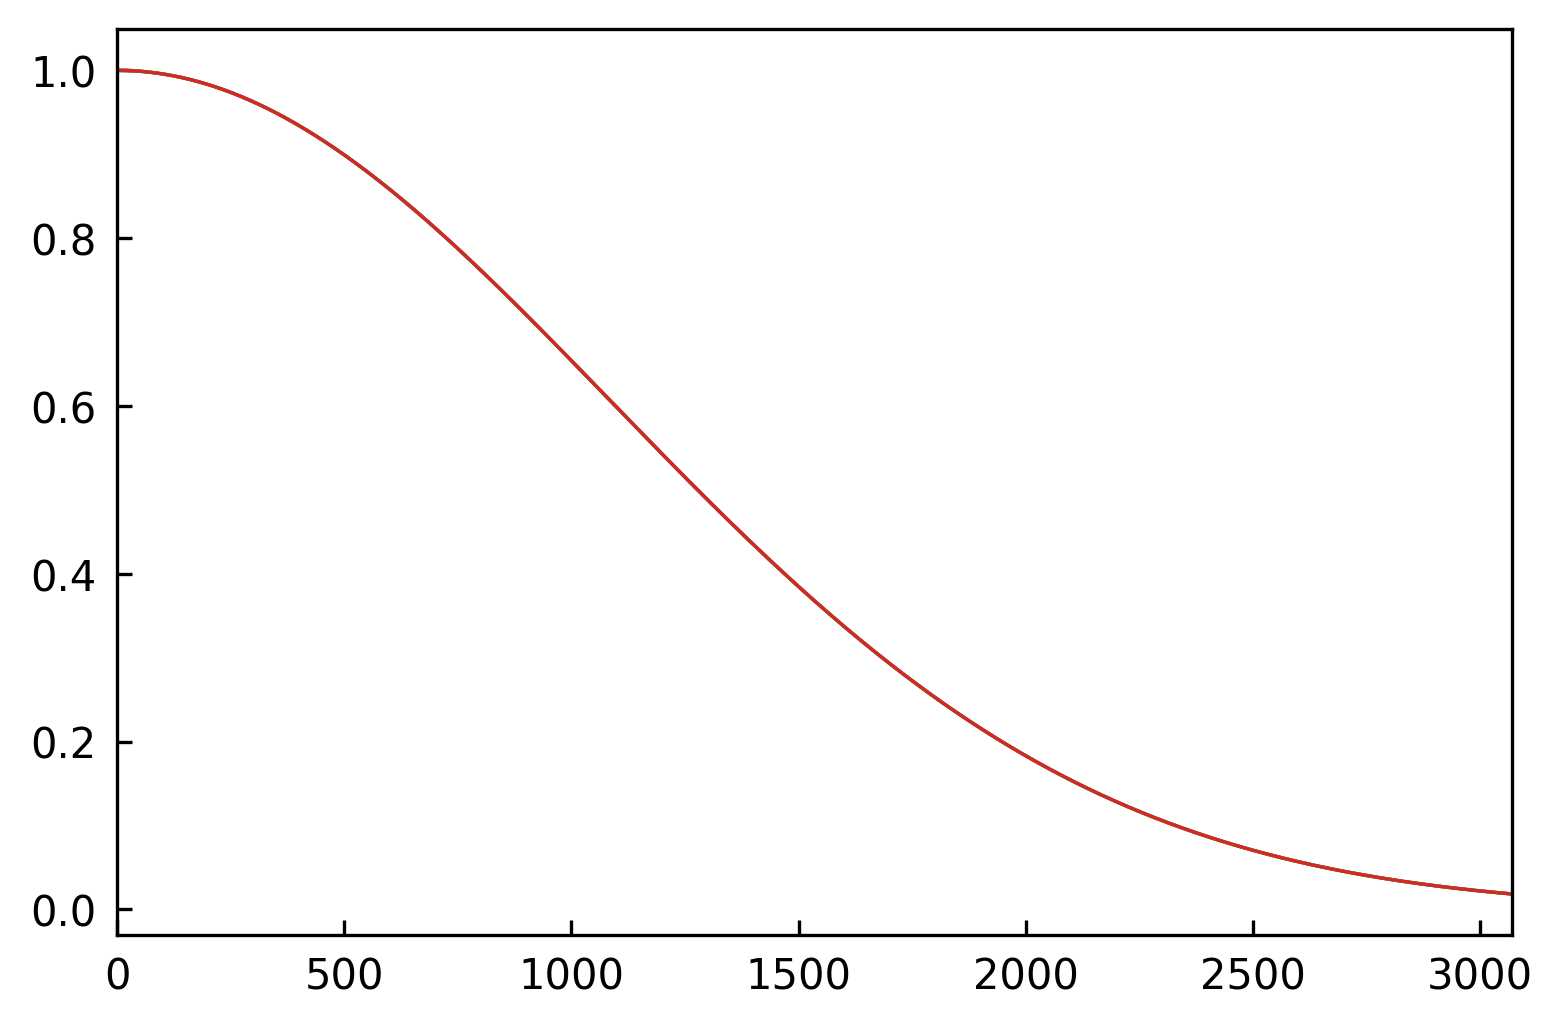

In [11]:
L = 3*nside 
lmax = L-1 
fwhm = 0.5 * np.pi / nside # smoothing size (don't ask how I picked this... arXiv:1306.0005)
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)
plt.plot(bl**2)
plt.xlim([0, lmax])

# Construct smoothed and extended masks to keep quasi-leakage-free regions of the sky
threshold = 0.99
mask_lm = hp.map2alm(QU_mask, lmax=lmax, pol=False) # scalar transform
mask_lm_sm = hp.smoothalm(mask_lm, fwhm=4*fwhm) # extra smoothing of the mask to deal with edges
mask_sm = hp.alm2map(mask_lm_sm, nside=1024, lmax=lmax, pol=False) # mask at adequate resolusion
mask_sm_t = 1*mask_sm
mask_sm_t[mask_sm >= threshold] = 1
mask_sm_t[mask_sm < threshold] = 0
mask_lm_sm2 = hp.map2alm(mask_sm_t, lmax=lmax, pol=False) # scalar transform
_ = hp.smoothalm(mask_lm_sm2, fwhm=4*fwhm, inplace=True) # extra smoothing of the mask to deal with edges
mask_sm2 = hp.alm2map(mask_lm_sm2, nside=nside, lmax=lmax, pol=False) # mask at adequate resolusion
mask = 1*mask_sm2
mask[mask < threshold] = 0
mask[mask > threshold] = 1

In [12]:
np.sum(mask>0)

38

# Now start doing mean shear vs. X

In [13]:
def mask_default(cat):
    mask0_default = (~((cat['mcal_T_noshear'][:]>2)*(cat['mcal_s2n_noshear'][:]<30)))*(cat['mcal_T_noshear'][:]<10)*(cat['mcal_s2n_noshear'][:]<1000)*(cat['mcal_s2n_noshear'][:]>10)*(cat['mcal_T_ratio_noshear'][:]>0.5)
    mask_1p_default = (~((cat['mcal_T_1p'][:]>2)*(cat['mcal_s2n_1p'][:]<30)))*(cat['mcal_T_1p'][:]<10)*(cat['mcal_s2n_1p'][:]<1000)*(cat['mcal_s2n_1p'][:]>10)*(cat['mcal_T_ratio_1p'][:]>0.5)
    mask_1m_default = (~((cat['mcal_T_1m'][:]>2)*(cat['mcal_s2n_1m'][:]<30)))*(cat['mcal_T_1m'][:]<10)*(cat['mcal_s2n_1m'][:]<1000)*(cat['mcal_s2n_1m'][:]>10)*(cat['mcal_T_ratio_1m'][:]>0.5)
    mask_2p_default = (~((cat['mcal_T_2p'][:]>2)*(cat['mcal_s2n_2p'][:]<30)))*(cat['mcal_T_2p'][:]<10)*(cat['mcal_s2n_2p'][:]<1000)*(cat['mcal_s2n_2p'][:]>10)*(cat['mcal_T_ratio_2p'][:]>0.5)
    mask_2m_default = (~((cat['mcal_T_2m'][:]>2)*(cat['mcal_s2n_2m'][:]<30)))*(cat['mcal_T_2m'][:]<10)*(cat['mcal_s2n_2m'][:]<1000)*(cat['mcal_s2n_2m'][:]>10)*(cat['mcal_T_ratio_2m'][:]>0.5)

    return mask0_default, mask_1p_default, mask_1m_default, mask_2p_default, mask_2m_default


In [14]:
def get_Rs(cat, m0, m_1p, m_1m, m_2p, m_2m):
    
    # calcualte metacalibration factors
    dgamma = 2*0.01
    
    R11  = (np.mean(cat['mcal_g_1p'][:,0][m0]) - np.mean(cat['mcal_g_1m'][:,0][m0]))/dgamma
    R11s = (np.mean(cat['mcal_g_noshear'][:,0][m_1p]) - np.mean(cat['mcal_g_noshear'][:,0][m_1m]))/dgamma
    R11tot = R11 + R11s

    R22  = (np.mean(cat['mcal_g_2p'][:,1][m0]) - np.mean(cat['mcal_g_2m'][:,1][m0]))/dgamma
    R22s = (np.mean(cat['mcal_g_noshear'][:,1][m_2p]) - np.mean(cat['mcal_g_noshear'][:,1][m_2m]))/dgamma
    R22tot = R22 + R22s
    
    return R11tot, R22tot
    

In [15]:
def calibrate_bin_X(cat, tag, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_1p = df_1p*(cat[tag+'_1p'][:]>lim1)*(cat[tag+'_1p'][:]<=lim2)
    mask_1m = df_1m*(cat[tag+'_1m'][:]>lim1)*(cat[tag+'_1m'][:]<=lim2)
    mask_2p = df_2p*(cat[tag+'_2p'][:]>lim1)*(cat[tag+'_2p'][:]<=lim2)
    mask_2m = df_2m*(cat[tag+'_2m'][:]>lim1)*(cat[tag+'_2m'][:]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot
    
    xmean = np.mean(cat[tag+'_noshear'][mask0])

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2), xmean


In [16]:
def calibrate_bin_Y(cat, tag, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_1p = df_1p*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_1m = df_1m*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_2p = df_2p*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_2m = df_2m*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot
    
    xmean = np.mean(cat[tag+'_noshear'][mask0])

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2), xmean


In [17]:
def calibrate_bin_Z(cat, tag, n, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_1p = df_1p*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_1m = df_1m*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_2p = df_2p*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_2m = df_2m*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot
    
    xmean = np.mean(cat[tag+'_noshear'][:,n][mask0])

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2), xmean


In [18]:
def calibrate_bin_A(cat, tag, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_1p = df_1p*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_1m = df_1m*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_2p = df_2p*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_2m = df_2m*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2)


In [19]:
def linear(param, x): 
    return param[0]*x+param[1]

def residual(param, func, x, y, var): 
    y_pred = func(param, x)
    return np.sum((y_pred-y)**2/var)

def linear_fit(x, y, var): 
    res = scipy.optimize.minimize(residual, [0,0], args=(linear, x, y, var), method=None)
    return res.x

### Mean shear vs. SNR

In [20]:
with h5py.File(delve_dir, 'r') as h5r:
    new = h5r['DATA']
    tag = 'mcal_s2n'
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(new)
    
    XX = []
    Npt = 10
    for i in tqdm.trange(0,Npt):
        s2n1 = np.percentile(new[f'{tag}_noshear'][df0],i*100/Npt)
        s2n2 = np.percentile(new[f'{tag}_noshear'][df0],(i+1)*100/Npt)

        X = calibrate_bin_X(new, tag, s2n1, s2n2)
        XX.append(X)
    XX = np.array(XX)

100%|██████████| 10/10 [02:00<00:00, 12.08s/it]


Text(0.5, 1.0, '$\\langle e\\rangle$ vs. Signal to Noise')

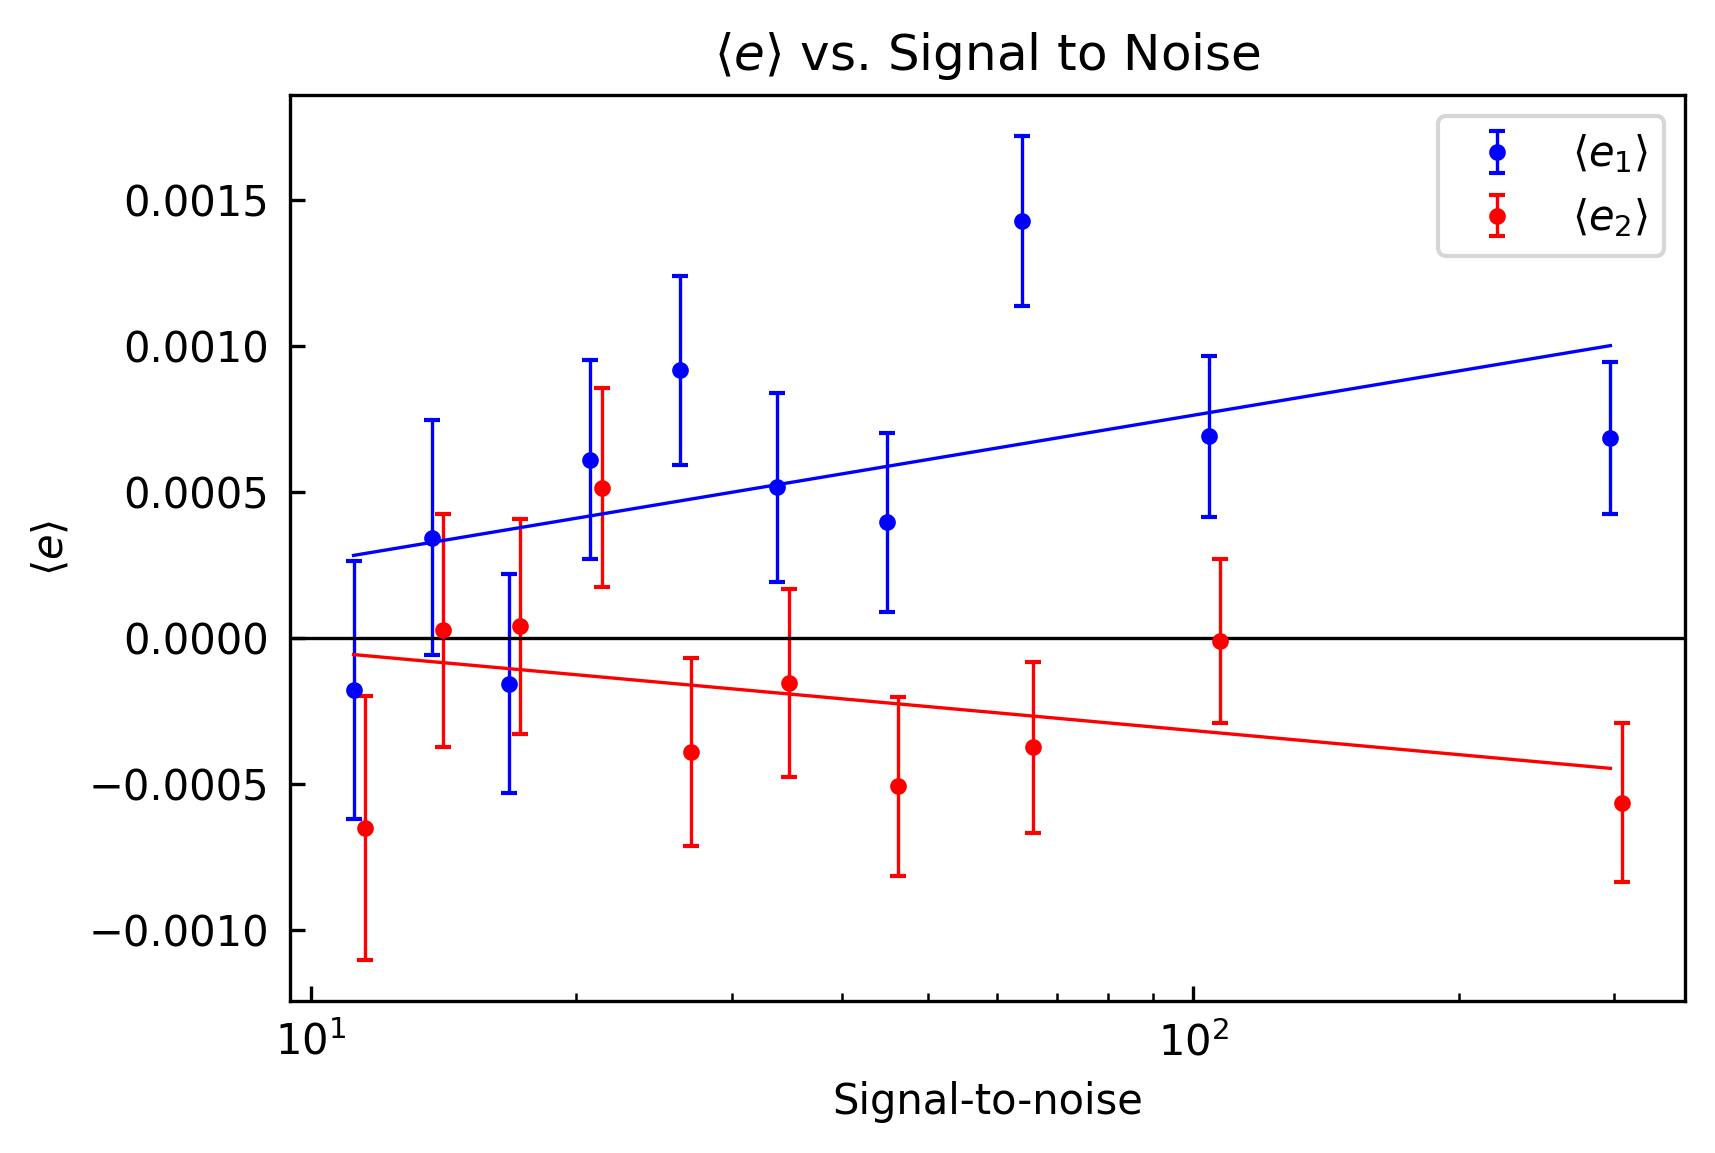

In [21]:
SNR = np.array(XX[:,-1])

plt.errorbar(SNR, XX[:,0], XX[:,2], label=r'$\langle e_1\rangle$', capsize=2, color='blue',fmt='o')
param1 = linear_fit(np.log(SNR), XX[:,0], XX[:,2])
plt.plot(SNR, linear(param1,np.log(SNR)),color='blue')

plt.errorbar(SNR*1.03, XX[:,1], XX[:,3], label=r'$\langle e_2\rangle$', capsize=2, color='red',fmt='o')
param2 = linear_fit(np.log(SNR), XX[:,1], XX[:,3])
plt.plot(SNR, linear(param2,np.log(SNR)),color='red')

plt.xscale('log')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.axhline(0,color='black')
plt.ylabel(r'$\langle e\rangle$')
plt.title(r'$\langle e\rangle$ vs. Signal to Noise')

### Mean shear vs. size ratio

In [22]:
with h5py.File(delve_dir, 'r') as h5r:
    new = h5r['DATA']
    tag = 'mcal_T_ratio'
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(new)
    
    XX = []
    Npt = 10
    for i in tqdm.trange(0,Npt):
        size1 = np.percentile(new[f'{tag}_noshear'][df0],i*100/Npt)
        size2 = np.percentile(new[f'{tag}_noshear'][df0],(i+1)*100/Npt)

        X = calibrate_bin_X(new, tag, size1, size2)
        XX.append(X)
    XX = np.array(XX)

100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


Text(0.5, 1.0, '$\\langle e\\rangle$ vs. T-ratio')

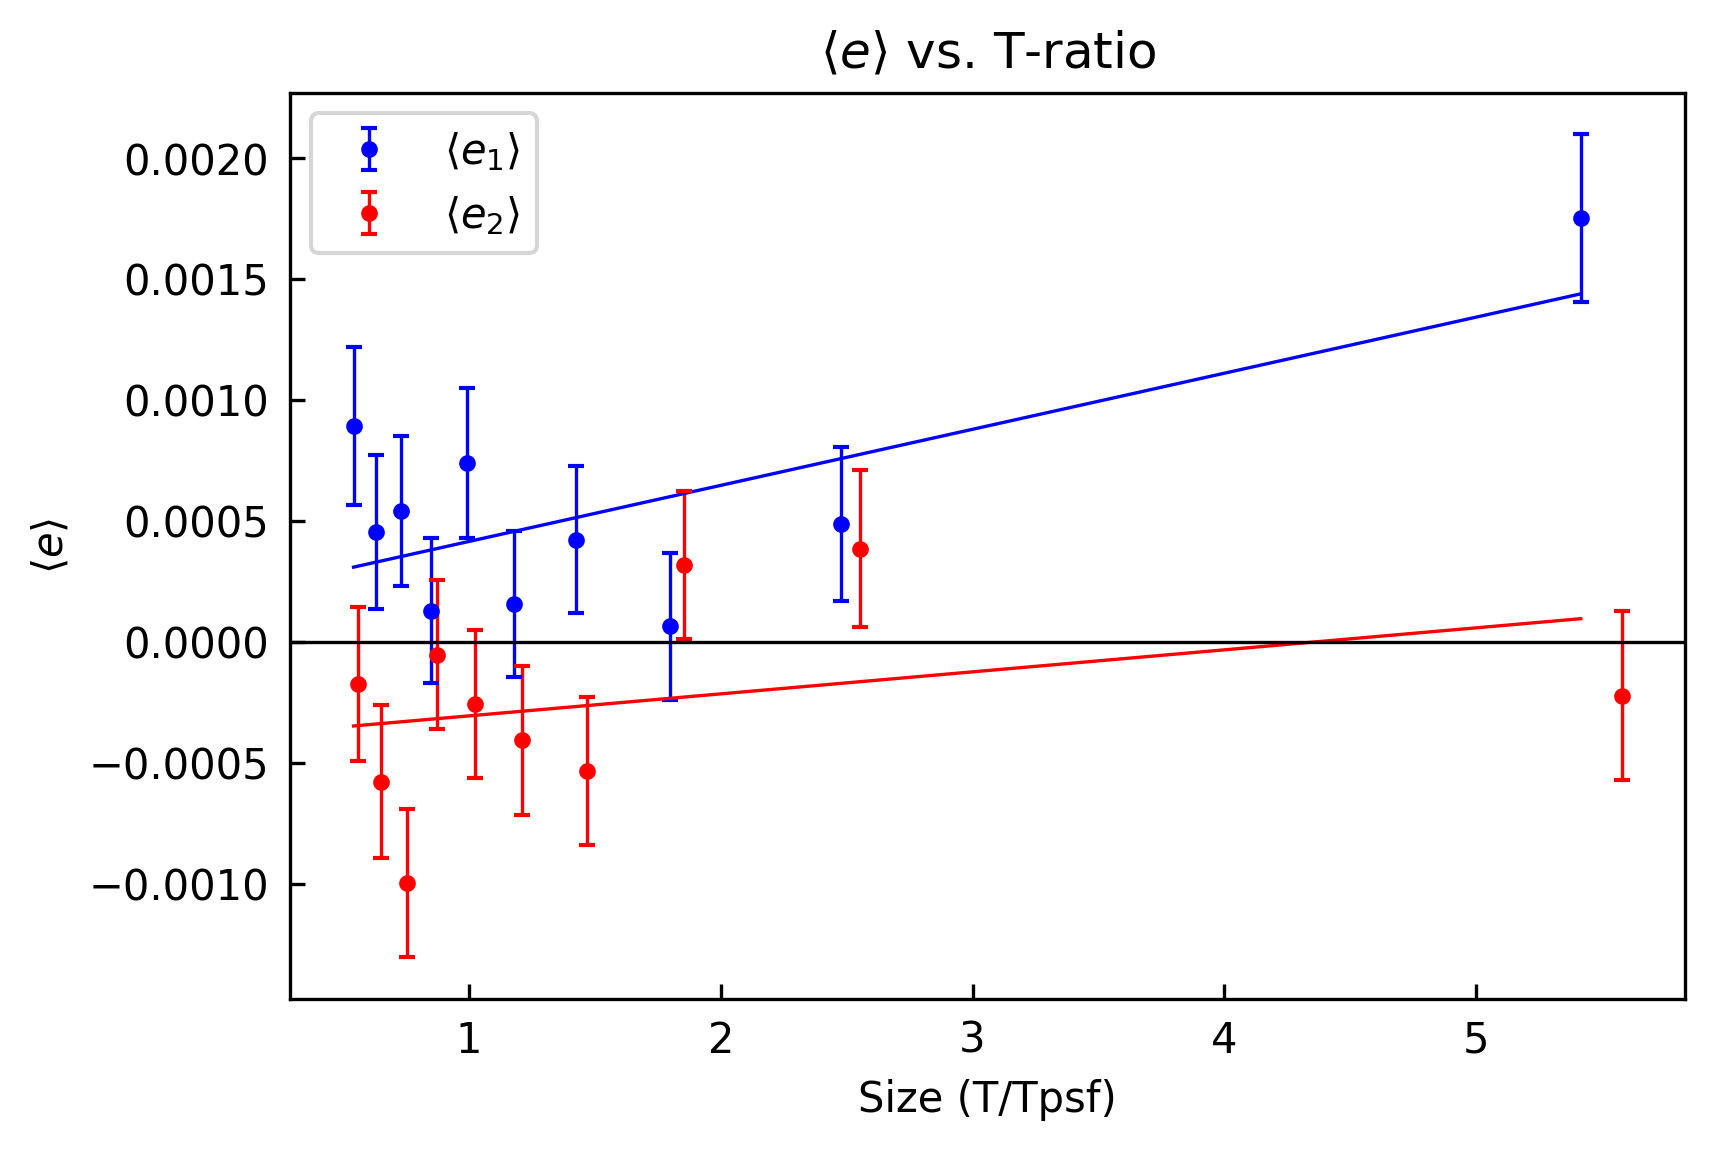

In [23]:
SNR = np.array(XX[:,-1])

plt.errorbar(SNR, XX[:,0], XX[:,2], label=r'$\langle e_1\rangle$', capsize=2, color='blue',fmt='o')
param1 = linear_fit(SNR, XX[:,0], XX[:,2])
plt.plot(SNR, linear(param1,SNR),color='blue')

plt.errorbar(SNR*1.03, XX[:,1], XX[:,3], label=r'$\langle e_2\rangle$', capsize=2, color='red',fmt='o')
param2 = linear_fit(SNR, XX[:,1], XX[:,3])
plt.plot(SNR, linear(param2,SNR),color='red')

#plt.xscale('log')
mplot.xlabel('Size (T/Tpsf)')
plt.legend()
plt.axhline(0,color='black')
plt.ylabel(r'$\langle e\rangle$')
plt.title(r'$\langle e\rangle$ vs. T-ratio')

### Mean shear vs. PSF size

In [24]:
with h5py.File(delve_dir, 'r') as h5r:
    new = h5r['DATA']
    tag = 'mcal_psf_T'
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(new)
    
    XX = []
    Npt = 10
    for i in tqdm.trange(0,Npt):
        size1 = np.percentile(new[f'{tag}_noshear'][df0],i*100/Npt)
        size2 = np.percentile(new[f'{tag}_noshear'][df0],(i+1)*100/Npt)

        X = calibrate_bin_Y(new, tag, size1, size2)
        XX.append(X)
    XX = np.array(XX)

100%|██████████| 10/10 [01:55<00:00, 11.57s/it]


Text(0.5, 1.0, '$\\langle e\\rangle$ vs. PSF size')

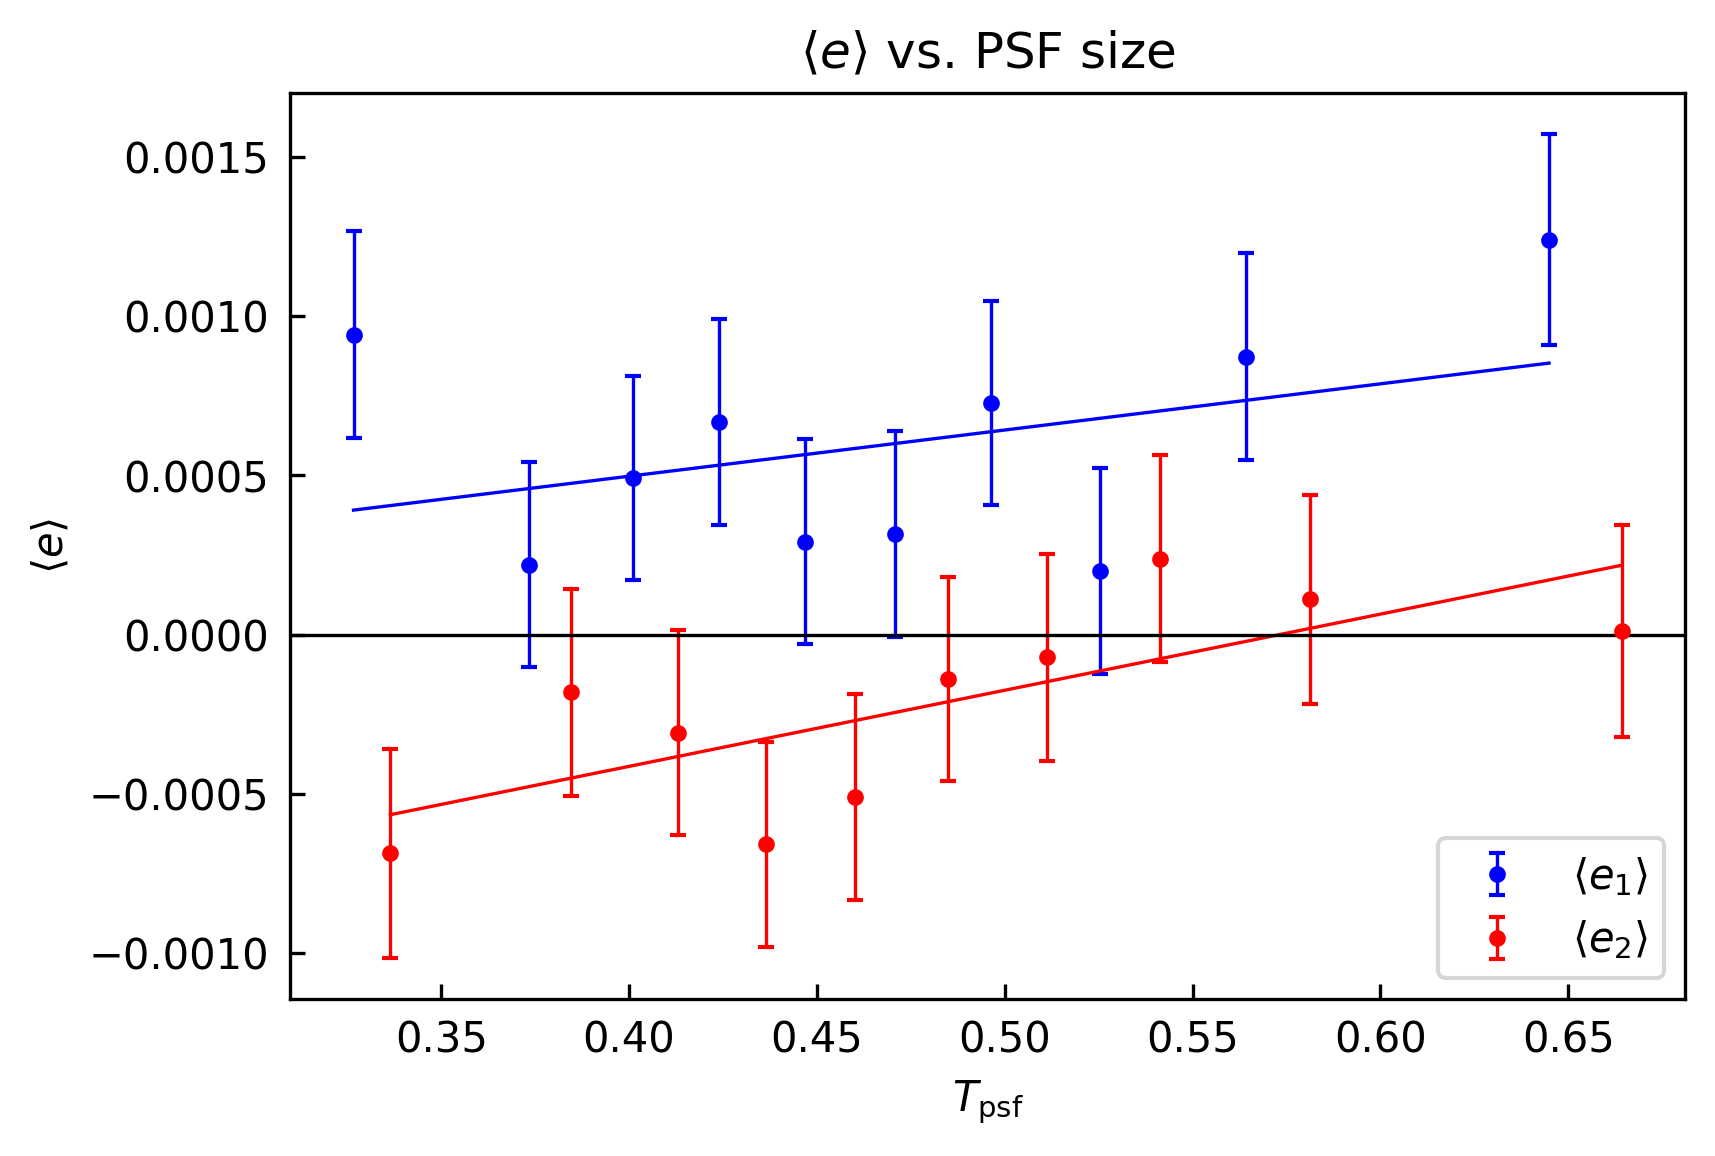

In [25]:
SNR = np.array(XX[:,-1])

plt.errorbar(SNR, XX[:,0], XX[:,2], label=r'$\langle e_1\rangle$', capsize=2, color='blue',fmt='o')
param1 = linear_fit(SNR, XX[:,0], XX[:,2])
plt.plot(SNR, linear(param1,SNR),color='blue')

plt.errorbar(SNR*1.03, XX[:,1], XX[:,3], label=r'$\langle e_2\rangle$', capsize=2, color='red',fmt='o')
param2 = linear_fit(SNR, XX[:,1], XX[:,3])
plt.plot(SNR*1.03, linear(param2,SNR),color='red')

plt.xlabel(r'$T_{\rm psf}$')
plt.legend()
plt.axhline(0,color='black')
plt.ylabel(r'$\langle e\rangle$')
plt.title(r'$\langle e\rangle$ vs. PSF size')

### PSF e1, e2

In [26]:
with h5py.File(delve_dir, 'r') as h5r:
    new = h5r['DATA']
    tag = 'mcal_psf_g'
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(new)
    
    XX = []
    Npt = 10
    for i in tqdm.trange(0,Npt):
        ee1 = np.percentile(new[f'{tag}_noshear'][:,0][df0],i*100/Npt)
        ee2 = np.percentile(new[f'{tag}_noshear'][:,0][df0],(i+1)*100/Npt)

        X = calibrate_bin_Z(new, tag, 0, ee1, ee2)
        XX.append(X)
    XX = np.array(XX)

100%|██████████| 10/10 [01:13<00:00,  7.39s/it]


-0.011875521477486084
-0.002549157025612744


Text(0, 0.5, '$\\langle e\\rangle$')

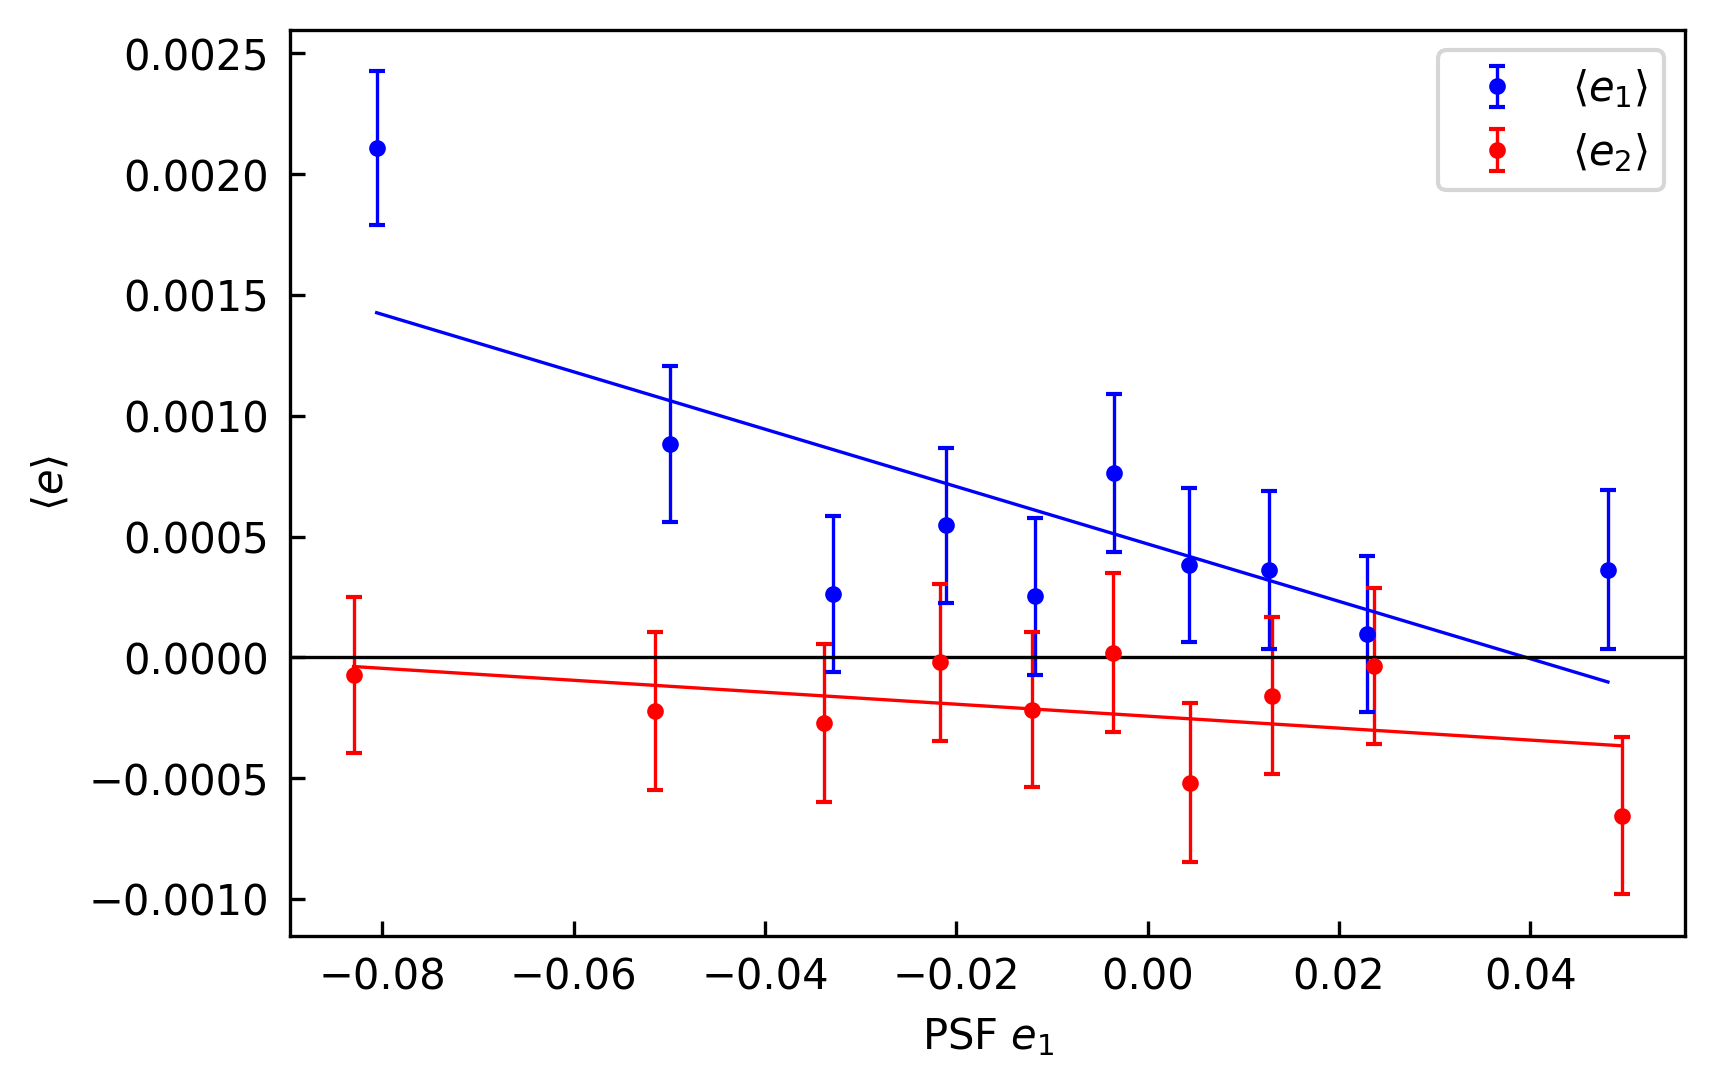

In [27]:
SNR = np.array(XX[:,-1])

plt.errorbar(SNR, XX[:,0], XX[:,2], label=r'$\langle e_1\rangle$', capsize=2, color='blue',fmt='o')
param1 = linear_fit(SNR, XX[:,0], XX[:,2])
plt.plot(SNR, linear(param1,SNR),color='blue')

print(param1[0])

plt.errorbar(SNR*1.03, XX[:,1], XX[:,3], label=r'$\langle e_2\rangle$', capsize=2, color='red',fmt='o')
param2 = linear_fit(SNR, XX[:,1], XX[:,3])
plt.plot(SNR*1.03, linear(param2,SNR),color='red')

print(param2[0])

plt.xlabel(r'PSF $e_1$')
plt.legend()
plt.axhline(0,color='black')
plt.ylabel(r'$\langle e\rangle$')

In [28]:
with h5py.File(delve_dir, 'r') as h5r:
    new = h5r['DATA']
    tag = 'mcal_psf_g'
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(new)
    
    XX = []
    Npt = 10
    for i in tqdm.trange(0,Npt):
        ee1 = np.percentile(new[f'{tag}_noshear'][:,1][df0],i*100/Npt)
        ee2 = np.percentile(new[f'{tag}_noshear'][:,1][df0],(i+1)*100/Npt)

        X = calibrate_bin_Z(new, tag, 1, ee1, ee2)
        XX.append(X)
    XX = np.array(XX)

100%|██████████| 10/10 [01:43<00:00, 10.37s/it]


0.004730887506445915
-0.0038724508668922476


Text(0, 0.5, '$\\langle e\\rangle$')

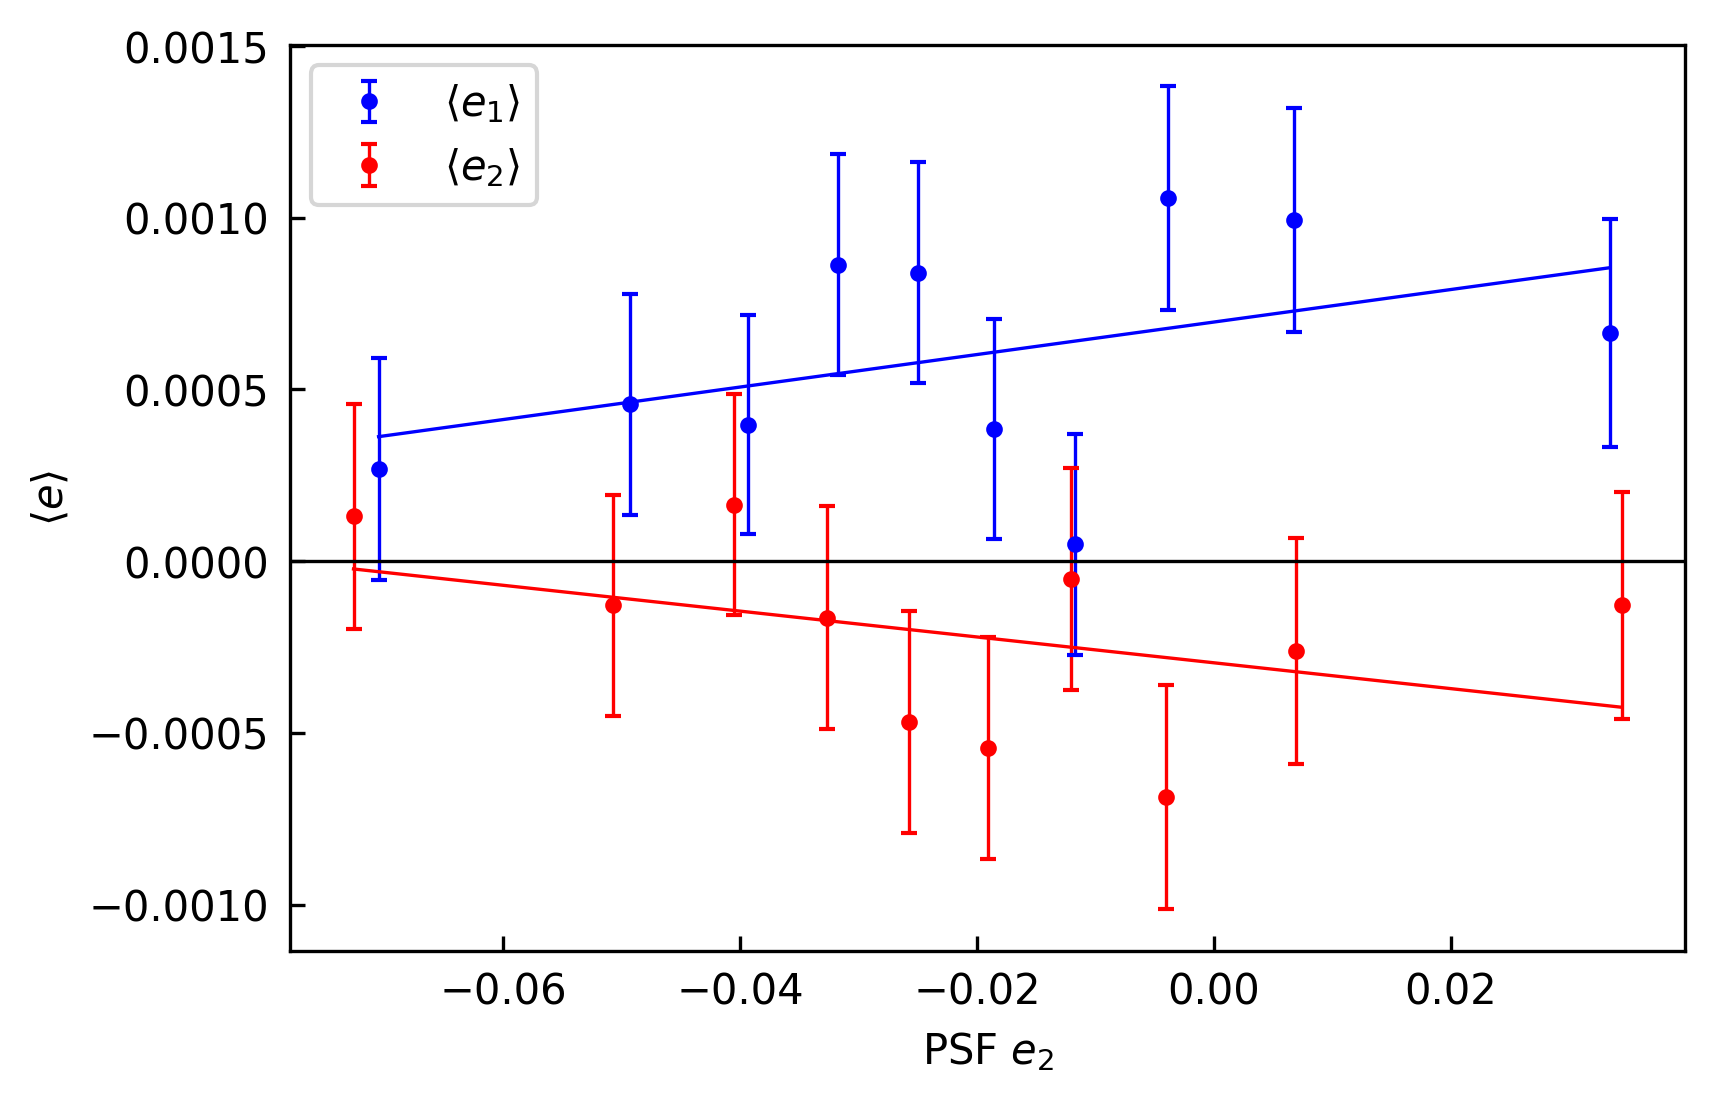

In [29]:
SNR = np.array(XX[:,-1])

plt.errorbar(SNR, XX[:,0], XX[:,2], label=r'$\langle e_1\rangle$', capsize=2, color='blue',fmt='o')
param1 = linear_fit(SNR, XX[:,0], XX[:,2])
plt.plot(SNR, linear(param1,SNR),color='blue')
print(param1[0])

plt.errorbar(SNR*1.03, XX[:,1], XX[:,3], label=r'$\langle e_2\rangle$', capsize=2, color='red',fmt='o')
param2 = linear_fit(SNR, XX[:,1], XX[:,3])
plt.plot(SNR*1.03, linear(param2,SNR),color='red')
print(param2[0])

plt.xlabel(r'PSF $e_2$')
plt.legend()
plt.axhline(0,color='black')
plt.ylabel(r'$\langle e\rangle$')